In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import joblib
import os


In [2]:
df = pd.read_csv("Bankruptcy Prediction.csv")
print("Rows:", df.shape[0], "Cols:", df.shape[1])
print("Target value counts:")
print(df['Bankrupt?'].value_counts())

Rows: 6819 Cols: 96
Target value counts:
Bankrupt?
0    6599
1     220
Name: count, dtype: int64


In [3]:
# 2) Quick EDA (head, dtypes, missing)
display(df.head())
print(df.dtypes.value_counts())
print("Missing values (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


float64    93
int64       3
Name: count, dtype: int64
Missing values (top 20):
Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
 Realized Sales Gross Margin                                0
 Operating Profit Rate                                      0
 Pre-tax net Interest Rate                                  0
 After-tax net Interest Rate                                0
 Non-industry income and expenditure/revenue                0
 Continuous interest rate (after tax)                       0
 Operating Expense Rate                                     0
 Research and development expense rate                      0
 Cash flow rate                                             0
 Interest-bearing debt interest rate                 

In [4]:
# 3) Prepare X and y; choose numeric features (most columns are numeric)
target_col = 'Bankrupt?'
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric features count:", len(numeric_cols))


Numeric features count: 95


In [5]:
# 4) Missing value handling (median for numeric)
imputer = SimpleImputer(strategy='median')
X_num_imputed = pd.DataFrame(imputer.fit_transform(X[numeric_cols]), columns=numeric_cols)


In [6]:
# 5) Outlier detection & treatment using IQR winsorization
def winsorize_iqr(df_in, cols, k=1.5):
    df = df_in.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df

X_wins = winsorize_iqr(X_num_imputed, numeric_cols, k=1.5)


#### Winsorization = replace extreme values with less-extreme values (caps), rather than removing those rows.

Two common ways:

Percentile winsorization: cap below the p-th percentile and above the (100-p)-th percentile. 

Example: cap below 1st percentile and above 99th percentile.

IQR-based winsorization: compute lower/upper using IQR rule (Q1 - kIQR, Q3 + kIQR) and cap values 

outside that range. That’s what your function does.

Why use it:

Keeps dataset size same (no row deletion).

Reduces the influence of extreme outliers on mean, standard deviation, correlation, and some models.

Often used before scaling or training models sensitive to outliers.

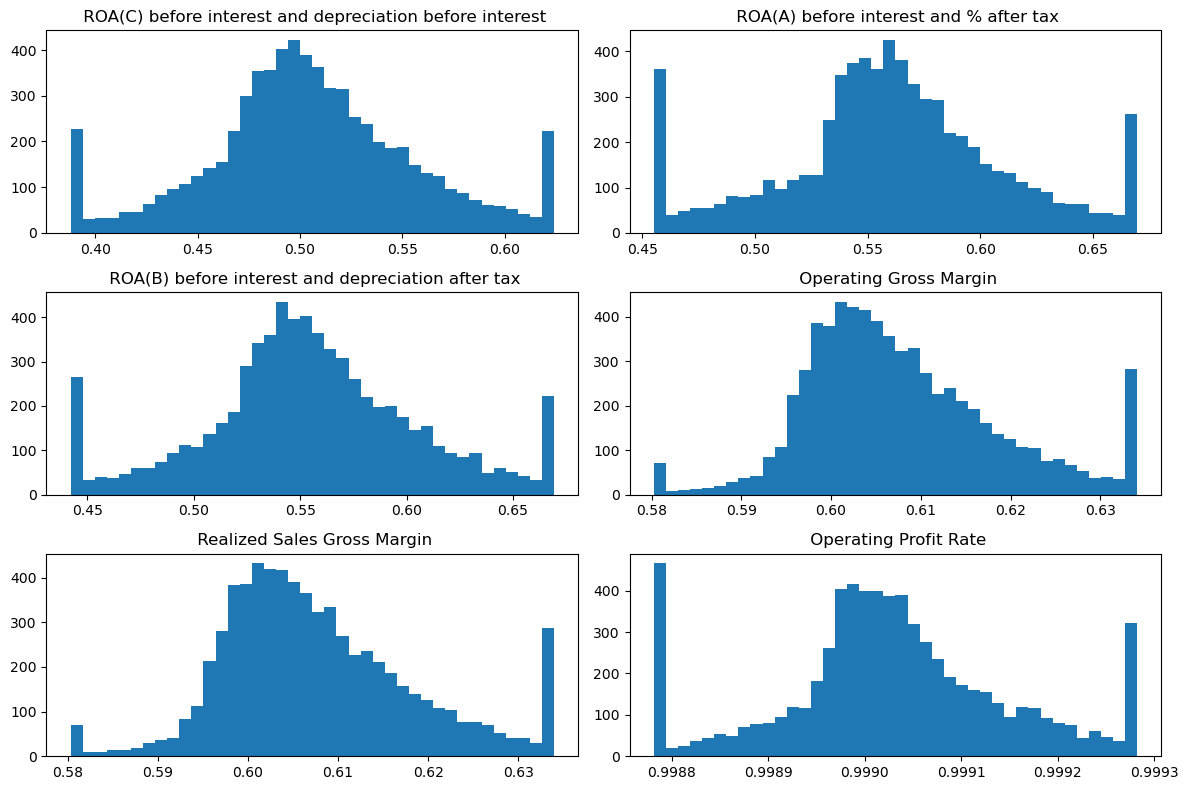

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax)
ROA(C) before interest and depreciation before interest,1.000000,0.941564,0.988614,0.471126,0.468962,0.794920,0.823454,0.810364,0.410102,0.836030
ROA(A) before interest and % after tax,0.941564,1.000000,0.952666,0.471641,0.469330,0.796013,0.876436,0.877649,0.505969,0.867825
ROA(B) before interest and depreciation after tax,0.988614,0.952666,1.000000,0.481338,0.479152,0.800215,0.829183,0.831419,0.412237,0.858169
Operating Gross Margin,0.471126,0.471641,0.481338,1.000000,0.999262,0.636798,0.542617,0.543808,0.108015,0.557557
Realized Sales Gross Margin,0.468962,0.469330,0.479152,0.999262,1.000000,0.636610,0.540578,0.541788,0.105757,0.555468
Operating Profit Rate,0.794920,0.796013,0.800215,0.636798,0.636610,1.000000,0.840959,0.829580,0.187141,0.851656
Pre-tax net Interest Rate,0.823454,0.876436,0.829183,0.542617,0.540578,0.840959,1.000000,0.987637,0.604490,0.961856
After-tax net Interest Rate,0.810364,0.877649,0.831419,0.543808,0.541788,0.829580,0.987637,1.000000,0.601598,0.968825
Non-industry income and expenditure/revenue,0.410102,0.505969,0.412237,0.108015,0.105757,0.187141,0.604490,0.601598,1.000000,0.537608
Continuous interest rate (after tax),0.836030,0.867825,0.858169,0.557557,0.555468,0.851656,0.961856,0.968825,0.537608,1.000000


In [7]:
# 6) Quick visualization: distributions of a few representative features + correlation heatmap
#Visual checks for shape of distributions and extreme skewness.
sample_cols = numeric_cols[:6]  # choose first 6 numeric columns to visualize
plt.figure(figsize=(12, 8))
for i, c in enumerate(sample_cols, 1):
    plt.subplot(3, 2, i)
    plt.hist(X_wins[c], bins=40)
    plt.title(c)
plt.tight_layout()
plt.show()

# Correlation of top features (by variance) to inspect relationships
corr = X_wins.corr().abs()
# show correlations of first 10 features as a quick check
display(corr.iloc[:10, :10])


In [8]:
# 7) Feature scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_wins), columns=numeric_cols)


In [9]:
# 8) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Train class dist:\n", y_train.value_counts())
print("Test class dist:\n", y_test.value_counts())


Train class dist:
 Bankrupt?
0    5279
1     176
Name: count, dtype: int64
Test class dist:
 Bankrupt?
0    1320
1      44
Name: count, dtype: int64


In [10]:
# 9) Handle imbalance with SMOTE (apply only to training set)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("After SMOTE - class distribution:\n", y_res.value_counts())


After SMOTE - class distribution:
 Bankrupt?
0    5279
1    5279
Name: count, dtype: int64


C:\Users\Shivani\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Shivani\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Shivani\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Shivani\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^

#  ROC & AUC Threshold-based Evaluations

### ROC curve checks model performance at all possible cutoff values from 0.0 → 1.0.

ROC Curve is a graph that checks how good your model is at separating classes(example: 0 = Not Fraud, 1 = Fraud).
It is a graph used to evaluate classification models, especially when the classes are imbalanced

### AUC = Area Under the ROC Curve It is a single number that tells you how good the model is overall, ignoring threshold. Higher AUC = better model

### Threshold-based Evaluations :A threshold (cutoff) decides when probability becomes class 1.

ROC curve + AUC score let us judge model performance independent of threshold.

### 🧠 Why do we use ROC & AUC?

Because they help us:

Compare models(e.g., RandomForest AUC = 0.89, Logistic AUC = 0.76)

Pick the right threshold(not always 0.5)

Understand sensitivity vs specificity trade-off

Evaluate model performance on imbalanced data(Accuracy alone fails here)

### 1. What is Sensitivity (also called Recall / True Positive Rate)?
   
“Out of all actual positive cases, how many did the model correctly catch?

Example:
If 100 people have a disease and your model detects 90 → Sensitivity = 0.90

### 2. What is False Positive Rate (FPR)?

Out of all actual negative cases, how many did the model wrongly mark as positive?”

Example:
If 100 healthy people → 10 wrongly predicted sick → FPR = 0.10





In [11]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, Xt, yt, name="Model"):
    preds = model.predict(Xt)
    probs = model.predict_proba(Xt)[:,1] if hasattr(model, "predict_proba") else model.decision_function(Xt)

    print(f"--- {name} ---")
    print(classification_report(yt, preds, digits=4))

    cm = confusion_matrix(yt, preds)
    print("Confusion Matrix:\n", cm)

    auc = roc_auc_score(yt, probs)
    print(f"ROC AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(yt, probs)

    return auc, fpr, tpr



#### What is the Trade-Off? (VERY IMPORTANT)

A trade-off means:

✔ If you make the model more sensitive → it catches more positives
✘ But it also produces more false positives

✔ If you reduce false positives
✘ Sensitivity drops, and you miss more actual positives

Why?
Because the trade-off depends on the threshold.

⭐ In Machine Learning (VERY IMPORTANT)

Especially in classification problems:

✔ Trade-Off = Sensitivity vs Specificity
🔹 Sensitivity (Recall):

“How many actual positives can you catch?”

🔹 Specificity:

“How well you avoid false positives?”

⭐ The Main ML Trade-Off
👉 **If you try to catch more positives (high sensitivity),

you will also accidentally catch more wrong ones (more false positives).**

👉 **If you reduce false positives,

you will also miss more real positives.**

You cannot maximize both together.

### confusion matrix
|          | Predicted 0 | Predicted 1 |
| -------- | ----------- | ----------- |
| Actual 0 | TN          | FP          |
| Actual 1 | FN          | TP          |


### ✅  1. Logistic Regression– GridSearchCV

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

In [13]:
lr_grid = {
    "C": [0.1, 1, 10],
    "solver": ["lbfgs"],
}

lr = LogisticRegression(max_iter=2000)
lr_cv = GridSearchCV(lr, lr_grid, cv=3, n_jobs=-1, scoring='roc_auc')
lr_cv.fit(X_res, y_res)

best_lr = lr_cv.best_estimator_
print("Best Logistic Regression:", best_lr)



Best Logistic Regression: LogisticRegression(C=10, max_iter=2000)


In [14]:
print(evaluate_model( best_lr, X_test, y_test, "Logistic Regression"))

--- Logistic Regression ---
              precision    recall  f1-score   support

           0     0.9924    0.8955    0.9415      1320
           1     0.2023    0.7955    0.3226        44

    accuracy                         0.8922      1364
   macro avg     0.5974    0.8455    0.6320      1364
weighted avg     0.9670    0.8922    0.9215      1364

Confusion Matrix:
 [[1182  138]
 [   9   35]]
ROC AUC: 0.9447
(np.float64(0.9447486225895317), array([0.00000000e+00, 7.57575758e-04, 7.57575758e-04, 2.27272727e-03,
       2.27272727e-03, 6.06060606e-03, 6.06060606e-03, 6.81818182e-03,
       6.81818182e-03, 7.57575758e-03, 7.57575758e-03, 9.09090909e-03,
       9.09090909e-03, 9.84848485e-03, 9.84848485e-03, 1.21212121e-02,
       1.21212121e-02, 1.28787879e-02, 1.28787879e-02, 1.51515152e-02,
       1.51515152e-02, 1.66666667e-02, 1.66666667e-02, 1.96969697e-02,
       1.96969697e-02, 2.27272727e-02, 2.27272727e-02, 2.50000000e-02,
       2.50000000e-02, 2.95454545e-02, 2.95454545e-02

### ✅ 2. Random Forest – GridSearchCV

In [15]:
rf_grid = {
    "n_estimators": [200, 400],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
}

rf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf, rf_grid, cv=3, n_jobs=-1, scoring='roc_auc')
rf_cv.fit(X_res, y_res)

best_rf = rf_cv.best_estimator_
print("Best Random Forest:", best_rf)


Best Random Forest: RandomForestClassifier(n_estimators=400, random_state=42)


In [16]:
print(evaluate_model(best_rf , X_test, y_test, " Random Forest"))

---  Random Forest ---
              precision    recall  f1-score   support

           0     0.9825    0.9811    0.9818      1320
           1     0.4565    0.4773    0.4667        44

    accuracy                         0.9648      1364
   macro avg     0.7195    0.7292    0.7242      1364
weighted avg     0.9656    0.9648    0.9652      1364

Confusion Matrix:
 [[1295   25]
 [  23   21]]
ROC AUC: 0.9506
(np.float64(0.9506112258953169), array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.57575758e-04,
       7.57575758e-04, 1.51515152e-03, 1.51515152e-03, 2.27272727e-03,
       2.27272727e-03, 6.81818182e-03, 6.81818182e-03, 1.06060606e-02,
       1.21212121e-02, 1.36363636e-02, 1.36363636e-02, 1.59090909e-02,
       1.59090909e-02, 1.81818182e-02, 1.81818182e-02, 1.89393939e-02,
       1.89393939e-02, 1.96969697e-02, 2.12121212e-02, 2.12121212e-02,
       2.19696970e-02, 2.50000000e-02, 2.57575758e-02, 2.57575758e-02,
       2.72727273e-02, 3.10606061e-02, 3.18181818e-02, 3.2

### ✅3.XGBboost– GridSearchCV

In [17]:
xgb = XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    use_label_encoder=False
)

xgb_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 6, 10],
}

xgb_cv = GridSearchCV(xgb, xgb_grid, cv=3, n_jobs=-1, scoring='roc_auc')
xgb_cv.fit(X_res, y_res)

best_xgb = xgb_cv.best_estimator_
print("Best XGBoost:", best_xgb)


C:\Users\Shivani\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:19:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)


In [18]:
print(evaluate_model(best_xgb , X_test, y_test, "XGBoost"))

--- XGBoost ---
              precision    recall  f1-score   support

           0     0.9834    0.9871    0.9853      1320
           1     0.5641    0.5000    0.5301        44

    accuracy                         0.9714      1364
   macro avg     0.7737    0.7436    0.7577      1364
weighted avg     0.9699    0.9714    0.9706      1364

Confusion Matrix:
 [[1303   17]
 [  22   22]]
ROC AUC: 0.9584
(np.float64(0.9583677685950414), array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.57575758e-04,
       7.57575758e-04, 1.51515152e-03, 1.51515152e-03, 3.03030303e-03,
       3.03030303e-03, 4.54545455e-03, 4.54545455e-03, 6.81818182e-03,
       6.81818182e-03, 7.57575758e-03, 7.57575758e-03, 9.09090909e-03,
       9.09090909e-03, 1.13636364e-02, 1.13636364e-02, 1.21212121e-02,
       1.21212121e-02, 1.28787879e-02, 1.28787879e-02, 1.51515152e-02,
       1.51515152e-02, 1.66666667e-02, 1.66666667e-02, 1.89393939e-02,
       1.89393939e-02, 2.42424242e-02, 2.42424242e-02, 2.65151515

### ✅ 4. KNN – GridSearchCV

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_grid, cv=3, n_jobs=-1, scoring="roc_auc")
knn_cv.fit(X_res, y_res)

best_knn = knn_cv.best_estimator_
print("Best KNN:", best_knn)


Best KNN: KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')


In [20]:
print(evaluate_model( best_knn , X_test, y_test, " KNN"))

---  KNN ---
              precision    recall  f1-score   support

           0     0.9924    0.8871    0.9368      1320
           1     0.1902    0.7955    0.3070        44

    accuracy                         0.8842      1364
   macro avg     0.5913    0.8413    0.6219      1364
weighted avg     0.9665    0.8842    0.9165      1364

Confusion Matrix:
 [[1171  149]
 [   9   35]]
ROC AUC: 0.9148
(np.float64(0.9147641184573002), array([0.        , 0.02348485, 0.025     , 0.025     , 0.02878788,
       0.02878788, 0.05378788, 0.05378788, 0.05530303, 0.05530303,
       0.06212121, 0.06212121, 0.06363636, 0.06363636, 0.08484848,
       0.08484848, 0.09545455, 0.09545455, 0.0969697 , 0.0969697 ,
       0.09772727, 0.09772727, 0.09848485, 0.09848485, 0.12575758,
       0.12575758, 0.1280303 , 0.1280303 , 0.14393939, 0.14393939,
       0.16060606, 0.16060606, 0.16212121, 0.16212121, 0.18409091,
       1.        ]), array([0.        , 0.45454545, 0.45454545, 0.54545455, 0.54545455,
       0

### ✅ 5. SVM (Support Vector Machine – SVC)

In [21]:
from sklearn.svm import SVC

svm_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

svm = SVC(probability=True)   # probability=True required for ROC AUC
svm_cv = GridSearchCV(svm, svm_grid, cv=3, n_jobs=-1, scoring="roc_auc")
svm_cv.fit(X_res, y_res)

best_svm = svm_cv.best_estimator_
print("Best SVM:", best_svm)


Best SVM: SVC(C=10, gamma='auto', probability=True)


In [22]:
print(evaluate_model( best_svm , X_test, y_test, " SVM"))

---  SVM ---
              precision    recall  f1-score   support

           0     0.9790    0.9879    0.9834      1320
           1     0.5000    0.3636    0.4211        44

    accuracy                         0.9677      1364
   macro avg     0.7395    0.6758    0.7022      1364
weighted avg     0.9635    0.9677    0.9653      1364

Confusion Matrix:
 [[1304   16]
 [  28   16]]
ROC AUC: 0.7945
(np.float64(0.7945247933884296), array([0.00000000e+00, 0.00000000e+00, 7.57575758e-04, 7.57575758e-04,
       1.51515152e-03, 1.51515152e-03, 3.03030303e-03, 3.03030303e-03,
       4.54545455e-03, 4.54545455e-03, 5.30303030e-03, 5.30303030e-03,
       7.57575758e-03, 7.57575758e-03, 8.33333333e-03, 8.33333333e-03,
       9.09090909e-03, 9.09090909e-03, 1.36363636e-02, 1.36363636e-02,
       1.59090909e-02, 1.59090909e-02, 1.81818182e-02, 1.81818182e-02,
       2.72727273e-02, 2.72727273e-02, 3.03030303e-02, 3.03030303e-02,
       3.48484848e-02, 3.48484848e-02, 3.93939394e-02, 3.93939394e-0

### ✅ 6. Decision Tree – GridSearchCV

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt_grid = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}

dt = DecisionTreeClassifier(random_state=42)
dt_cv = GridSearchCV(dt, dt_grid, cv=3, n_jobs=-1, scoring="roc_auc")
dt_cv.fit(X_res, y_res)

best_dt = dt_cv.best_estimator_
print("Best Decision Tree:", best_dt)


Best Decision Tree: DecisionTreeClassifier(min_samples_split=10, random_state=42)


In [24]:
print(evaluate_model( best_dt , X_test, y_test, " Decision Tree"))

---  Decision Tree ---
              precision    recall  f1-score   support

           0     0.9790    0.9523    0.9654      1320
           1     0.2125    0.3864    0.2742        44

    accuracy                         0.9340      1364
   macro avg     0.5957    0.6693    0.6198      1364
weighted avg     0.9542    0.9340    0.9431      1364

Confusion Matrix:
 [[1257   63]
 [  27   17]]
ROC AUC: 0.7518
(np.float64(0.7517820247933885), array([0.        , 0.04469697, 0.04469697, 0.04621212, 0.0469697 ,
       0.04772727, 0.05075758, 0.05151515, 0.05227273, 0.0530303 ,
       0.05378788, 0.05378788, 0.05833333, 0.05984848, 0.06060606,
       1.        ]), array([0.        , 0.34090909, 0.36363636, 0.36363636, 0.38636364,
       0.38636364, 0.43181818, 0.47727273, 0.47727273, 0.5       ,
       0.5       , 0.52272727, 0.56818182, 0.56818182, 0.56818182,
       1.        ]))


### Evaluate ALL Best Models

In [25]:
results = {}

results['Logistic Regression'] = evaluate_model(best_lr, X_test, y_test)
results['Random Forest'] = evaluate_model(best_rf, X_test, y_test)
results['XGBoost'] = evaluate_model(best_xgb, X_test, y_test)
results['KNN'] = evaluate_model(best_knn, X_test, y_test)
results['SVM'] = evaluate_model(best_svm, X_test, y_test)
results['Decision Tree'] = evaluate_model(best_dt, X_test, y_test)

print("\n\n===== FINAL MODEL SCORES =====")
print(results)


--- Model ---
              precision    recall  f1-score   support

           0     0.9924    0.8955    0.9415      1320
           1     0.2023    0.7955    0.3226        44

    accuracy                         0.8922      1364
   macro avg     0.5974    0.8455    0.6320      1364
weighted avg     0.9670    0.8922    0.9215      1364

Confusion Matrix:
 [[1182  138]
 [   9   35]]
ROC AUC: 0.9447
--- Model ---
              precision    recall  f1-score   support

           0     0.9825    0.9811    0.9818      1320
           1     0.4565    0.4773    0.4667        44

    accuracy                         0.9648      1364
   macro avg     0.7195    0.7292    0.7242      1364
weighted avg     0.9656    0.9648    0.9652      1364

Confusion Matrix:
 [[1295   25]
 [  23   21]]
ROC AUC: 0.9506
--- Model ---
              precision    recall  f1-score   support

           0     0.9834    0.9871    0.9853      1320
           1     0.5641    0.5000    0.5301        44

    accuracy    

### Select Best Model Automatically

In [26]:
best_model_name = max(results, key=results.get)
print("\nBest Model is:", best_model_name)

if best_model_name == "Logistic Regression":
    best_model = best_lr
elif best_model_name == "Random Forest":
    best_model = best_rf
elif best_model_name == "XGBoost":
    best_model = best_xgb
elif best_model_name == "SVM":
    best_model = best_svm
elif best_model_name == "KNN": 
    best_model =best_knn
else:
    best_model = best_dt

    
    


    



Best Model is: XGBoost


In [27]:
rf_auc, rf_fpr, rf_tpr = evaluate_model(best_rf, X_test, y_test, "Random Forest")
xgb_auc, xgb_fpr, xgb_tpr= evaluate_model(best_xgb, X_test, y_test, "XGBboost")

--- Random Forest ---
              precision    recall  f1-score   support

           0     0.9825    0.9811    0.9818      1320
           1     0.4565    0.4773    0.4667        44

    accuracy                         0.9648      1364
   macro avg     0.7195    0.7292    0.7242      1364
weighted avg     0.9656    0.9648    0.9652      1364

Confusion Matrix:
 [[1295   25]
 [  23   21]]
ROC AUC: 0.9506
--- XGBboost ---
              precision    recall  f1-score   support

           0     0.9834    0.9871    0.9853      1320
           1     0.5641    0.5000    0.5301        44

    accuracy                         0.9714      1364
   macro avg     0.7737    0.7436    0.7577      1364
weighted avg     0.9699    0.9714    0.9706      1364

Confusion Matrix:
 [[1303   17]
 [  22   22]]
ROC AUC: 0.9584


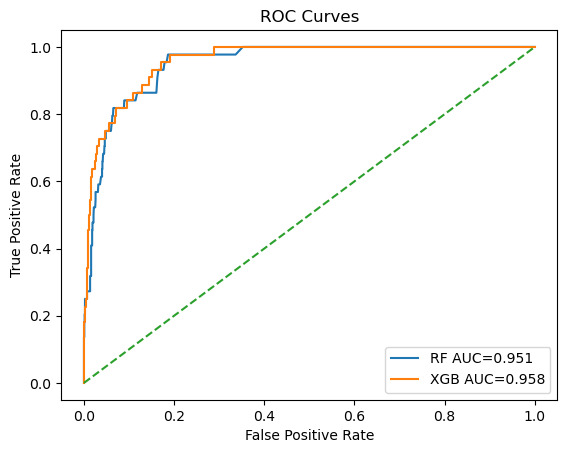

In [28]:
# 12) Plot ROC curves (matplotlib)
plt.figure()
plt.plot(rf_fpr, rf_tpr, label=f"RF AUC={rf_auc:.3f}")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGB AUC={xgb_auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


### It means:
XGBboost is clearly better

It catches positives better (higher TPR)

It makes fewer mistakes (lower FPR)

It is more trustworthy in your dataset

## Saving Model


In [29]:
knn_auc, knn_fpr, knn_tpr = evaluate_model(best_knn, X_test, y_test, "KNN")
svm_auc, svm_fpr, svm_tpr= evaluate_model(best_svm, X_test, y_test, "SVM")
dt_auc, dt_fpr, dt_tpr = evaluate_model(best_dt, X_test, y_test, "Decision Tree")
lr_auc, lr_fpr, lr_tpr= evaluate_model(best_lr, X_test, y_test, "Logistic Regression")

--- KNN ---
              precision    recall  f1-score   support

           0     0.9924    0.8871    0.9368      1320
           1     0.1902    0.7955    0.3070        44

    accuracy                         0.8842      1364
   macro avg     0.5913    0.8413    0.6219      1364
weighted avg     0.9665    0.8842    0.9165      1364

Confusion Matrix:
 [[1171  149]
 [   9   35]]
ROC AUC: 0.9148
--- SVM ---
              precision    recall  f1-score   support

           0     0.9790    0.9879    0.9834      1320
           1     0.5000    0.3636    0.4211        44

    accuracy                         0.9677      1364
   macro avg     0.7395    0.6758    0.7022      1364
weighted avg     0.9635    0.9677    0.9653      1364

Confusion Matrix:
 [[1304   16]
 [  28   16]]
ROC AUC: 0.7945
--- Decision Tree ---
              precision    recall  f1-score   support

           0     0.9790    0.9523    0.9654      1320
           1     0.2125    0.3864    0.2742        44

    accuracy

In [30]:
import pandas as pd
import joblib
from xgboost import XGBClassifier

# Load data
df = pd.read_csv("Bankruptcy Prediction.csv")

# Split X and y correctly
X = df.drop("Bankrupt?", axis=1)
y = df["Bankrupt?"]

# Retrain model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

# Save clean model
joblib.dump(model, "bankruptcy_best_model.pkl")

print("✅ Clean model saved successfully")


C:\Users\Shivani\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:32:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Clean model saved successfully
